# Preprocessing
---

In [28]:
import pandas as pd
import numpy as np

> # 모두 이상치 확인(boxplot) & 제거 필요

In [294]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    return x.rjust(6, "0")

# 2. 중복인 거래소코드(column) 찾기
def find_overlap(df, column):
    NCAV1_name = df[column].unique().tolist()
    rm_list = list()

    for i in NCAV1_name:
        if (len(df[df[column]==i]) > 1):
            rm_list.append(i)
    return rm_list

# 3. 종목 표준코드 12자가 아닌게 있나?
def find_over12(df, col):
    rm = list()
    for i in range(len(df[col])):
        if len(df[col][i]) != 12:
            rm.append(i)
    return rm
## find_over12(foreign_kospi_18, "종목코드")


# 4. 표준코드를 단축코드로! 12자 중 중간 6자 반환
def extract_code(x):
    return x[3:9]

# 5. True, False 반전
def reverse_TF(x):
    if x == False:
        return True
    else:
        return False


# 1. 펀더멘탈지표
- NCAV : (유동자산 - 총부채) / 시가총액
    - 벤자민 그레이엄의 핵심 지표
- PEGR : **PER(전일_21년도3월31일)** / **EPS 증가율(3년평균)**
    - 피터 린치의 핵심 지표
- PSR : **현재주가(21.03.31)** / **1주당 매출액(20년)**
    - 켄 피셔의 핵심 지표
- **유동비율(20년도)**
    - 유동자산의 유동부채에 대한 비율
- **부채비율(20년도)**

## 1-1. NCAV
> (유동자산 - 총부채) / 시가총액

### 1-1-1. 유동자산_총부채 전처리

In [30]:
NCAV1 = pd.read_csv("./datasets/raw/NCAV(유동자산_총부채).csv", encoding="CP949")
NCAV1

,회사명,거래소코드,회계년도,유동자산(요약)(백만원),부채총계(요약)(백만원)
0,(주)BNK금융지주,138930,2020/12,NaN,NaN
1,(주)CMG제약,58820,2020/12,145981.0,14225.0
2,(주)DB하이텍,990,2020/12,455643.0,384020.0
3,(주)ES큐브,50120,2020/12,7524.0,9046.0
4,(주)HJ중공업,97230,2020/12,1067320.0,1868707.0
...,...,...,...,...,...
2303,휴마시스(주),205470,2020/12,42484.0,19508.0
2304,휴젤(주),145020,2020/12,552590.0,191023.0
2305,흥구석유(주),24060,2020/12,27688.0,4121.0
2306,흥국화재해상보험(주),540,2020/12,NaN,NaN


In [31]:
# 중복인 거래소코드 찾기
find_overlap(NCAV1, "거래소코드")

[108320]

In [32]:
NCAV1[NCAV1["거래소코드"]==108320]

,회사명,거래소코드,회계년도,유동자산(요약)(백만원),부채총계(요약)(백만원)
744,(주)엘엑스세미콘,108320,2020/12,627617.0,218870.0
745,(주)엘엑스세미콘,108320,2020/12,627617.0,218870.0


In [33]:
NCAV1.drop(index=744, axis=0, inplace=True) # 중복회사 데이터 단일화 완료
NCAV1.columns = ['회사명', '종목코드', '회계년도', '유동자산(백만원)', '부채총계(백만원)']
NCAV1["종목코드"] = NCAV1["종목코드"].astype("str")
NCAV1["종목코드"] = NCAV1["종목코드"].map(padding)
NCAV1

,회사명,종목코드,회계년도,유동자산(백만원),부채총계(백만원)
0,(주)BNK금융지주,138930,2020/12,NaN,NaN
1,(주)CMG제약,058820,2020/12,145981.0,14225.0
2,(주)DB하이텍,000990,2020/12,455643.0,384020.0
3,(주)ES큐브,050120,2020/12,7524.0,9046.0
4,(주)HJ중공업,097230,2020/12,1067320.0,1868707.0
...,...,...,...,...,...
2303,휴마시스(주),205470,2020/12,42484.0,19508.0
2304,휴젤(주),145020,2020/12,552590.0,191023.0
2305,흥구석유(주),024060,2020/12,27688.0,4121.0
2306,흥국화재해상보험(주),000540,2020/12,NaN,NaN


### 1-1-2. 시가총액 전처리

In [34]:
NCAV2_kospi = pd.read_csv("./datasets/raw/KOSPI_시가총액(20210331).csv", encoding="CP949")
NCAV2_kosdaq = pd.read_csv("./datasets/raw/KOSDAQ_시가총액(20210331).csv", encoding="CP949")
NCAV2 = pd.concat([NCAV2_kospi,NCAV2_kosdaq], axis=0).reset_index()
NCAV2 = NCAV2[["종목코드", "시가총액"]]
NCAV2["종목코드"] = NCAV2["종목코드"].map(padding)
NCAV2["시가총액"]= NCAV2["시가총액"]/1000000
NCAV2

,종목코드,시가총액
0,095570,2.109340e+05
1,006840,3.537100e+05
2,027410,6.709750e+05
3,282330,2.730860e+06
4,138930,2.213100e+06
...,...,...
2414,024060,1.087500e+05
2415,010240,1.168190e+05
2416,189980,2.080580e+05
2417,037440,6.620137e+04


### 1-1-3. NCAV 계산

In [35]:
df_NCAV = pd.merge(NCAV1, NCAV2, on=['종목코드'], how = 'inner') # 회사수가 적은 쪽을 기준으로 합친다.(2307 vs 2419)
df_NCAV

,회사명,종목코드,회계년도,유동자산(백만원),부채총계(백만원),시가총액
0,(주)BNK금융지주,138930,2020/12,NaN,NaN,2.213100e+06
1,(주)CMG제약,058820,2020/12,145981.0,14225.0,6.090420e+05
2,(주)DB하이텍,000990,2020/12,455643.0,384020.0,2.499640e+06
3,(주)ES큐브,050120,2020/12,7524.0,9046.0,6.944812e+04
4,(주)HJ중공업,097230,2020/12,1067320.0,1868707.0,6.212260e+05
...,...,...,...,...,...,...
2302,휴마시스(주),205470,2020/12,42484.0,19508.0,2.313530e+05
2303,휴젤(주),145020,2020/12,552590.0,191023.0,2.228650e+06
2304,흥구석유(주),024060,2020/12,27688.0,4121.0,1.087500e+05
2305,흥국화재해상보험(주),000540,2020/12,NaN,NaN,2.637160e+05


In [36]:
# (유동자산 - 총부채) / 시가총액
df_NCAV["NCAV"] = (df_NCAV["유동자산(백만원)"] - df_NCAV["부채총계(백만원)"]) / df_NCAV["시가총액"] # 컬럼생성
df_NCAV.drop(['유동자산(백만원)', '부채총계(백만원)', '시가총액'], axis=1, inplace=True) # 기존 컬럼 제거
df_NCAV.dropna(axis=0, inplace=True) # 결측치 제거
df_NCAV # 끝!

,회사명,종목코드,회계년도,NCAV
1,(주)CMG제약,058820,2020/12,0.216333
2,(주)DB하이텍,000990,2020/12,0.028653
3,(주)ES큐브,050120,2020/12,-0.021916
4,(주)HJ중공업,097230,2020/12,-1.290009
7,(주)MH에탄올,023150,2020/12,-0.301897
...,...,...,...,...
2301,휴림로봇(주),090710,2020/12,-0.133651
2302,휴마시스(주),205470,2020/12,0.099311
2303,휴젤(주),145020,2020/12,0.162236
2304,흥구석유(주),024060,2020/12,0.216708


## 1-2. PEGR
> PER(전일_21년도3월31일) / EPS 증가율(3년평균)

### 1-2-1. PER 전처리

In [37]:
PEGR1 = pd.read_csv("./datasets/raw/KOSPI_PER_PBR_20210331.csv", index_col=0)
PEGR1["종목코드"] = PEGR1["종목코드"].map(padding)
PEGR1 = PEGR1[["종목코드", "PER"]]

PEGR2 = pd.read_csv("./datasets/raw/KOSDAQ_PER_PBR_20210331.csv", index_col=0)
PEGR2["종목코드"] = PEGR2["종목코드"].map(padding)
PEGR2 = PEGR2[["종목코드", "PER"]]

PEGR_PER = pd.concat([PEGR1,PEGR2], axis=0)
PEGR_PER

,종목코드,PER
0,095570,4.59
1,006840,12.32
2,027410,24.95
3,282330,18.03
4,138930,4.12
...,...,...
1469,024060,12.72
1470,010240,16.69
1471,189980,35.89
1472,037440,16.51


### 1-2-2. EPS 전처리

<img width="454" alt="image" src="https://user-images.githubusercontent.com/88031549/201609333-de085c2c-b393-4714-a978-13a4fb3116a5.png">

In [304]:
EPS_kospi_18 = pd.read_csv("./datasets/raw/코스피_EPS_2018.csv", encoding="CP949", index_col=0)
EPS_kospi_18 = EPS_kospi_18[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kospi_18.columns = ["종목코드", "EPS_2018"]

EPS_kospi_21 = pd.read_csv("./datasets/raw/코스피_EPS_2021.csv", encoding="CP949", index_col=0)
EPS_kospi_21 = EPS_kospi_21[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kospi_21.columns = ["종목코드", "EPS_2021"]

EPS_kospi = pd.merge(EPS_kospi_18, EPS_kospi_21, on=['종목코드'], how = 'inner')
EPS_kospi["EPS증가율(3년)"] = ((EPS_kospi["EPS_2021"]/EPS_kospi["EPS_2018"])**(1/3) - 1)*100
# EPS_kospi.isna().sum() # 192개 제거
EPS_kospi.dropna(axis=0, inplace=True)
EPS_kospi = EPS_kospi[["종목코드", "EPS증가율(3년)"]]
EPS_kospi = EPS_kospi[np.isinf(abs(EPS_kospi["EPS증가율(3년)"])).map(reverse_TF)] # inf 제거
EPS_kospi

,종목코드,EPS증가율(3년)
0,095570,50.512649
1,068400,26.913469
2,006840,-27.052228
3,027410,-58.085336
5,138930,2.665923
...,...,...
843,081660,-46.377207
844,005870,-24.211060
845,079980,-100.000000
847,069260,17.464183


In [305]:
EPS_kosdaq_18 = pd.read_csv("./datasets/raw/코스닥_EPS_2018.csv", encoding="CP949", index_col=0)
EPS_kosdaq_18 = EPS_kosdaq_18[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kosdaq_18.columns = ["종목코드", "EPS_2018"]

EPS_kosdaq_21 = pd.read_csv("./datasets/raw/코스닥_EPS_2021.csv", encoding="CP949", index_col=0)
EPS_kosdaq_21 = EPS_kosdaq_21[["醫낅ぉ肄붾뱶", "EPS"]]
EPS_kosdaq_21.columns = ["종목코드", "EPS_2021"]

EPS_kosdaq = pd.merge(EPS_kosdaq_18, EPS_kosdaq_21, on=['종목코드'], how = 'inner')
EPS_kosdaq["EPS증가율(3년)"] = ((EPS_kosdaq["EPS_2021"]/EPS_kosdaq["EPS_2018"])**(1/3) - 1)*100
# EPS_kosdaq.isna().sum() # 254개 제거
EPS_kosdaq.dropna(axis=0, inplace=True)
EPS_kosdaq = EPS_kosdaq[["종목코드", "EPS증가율(3년)"]]
EPS_kosdaq = EPS_kosdaq[np.isinf(abs(EPS_kosdaq["EPS증가율(3년)"])).map(reverse_TF)] # inf 제거
EPS_kosdaq

,종목코드,EPS증가율(3년)
1,054620,-100.000000
3,211270,-52.404085
4,035760,10.967868
6,058820,9.579371
7,023460,67.638764
...,...,...
1189,024060,56.049075
1190,010240,-1.090787
1191,189980,-31.751290
1192,037440,19.920107


In [306]:
df_EPS = pd.concat([EPS_kospi, EPS_kosdaq], axis=0)
df_EPS

,종목코드,EPS증가율(3년)
0,095570,50.512649
1,068400,26.913469
2,006840,-27.052228
3,027410,-58.085336
5,138930,2.665923
...,...,...
1189,024060,56.049075
1190,010240,-1.090787
1191,189980,-31.751290
1192,037440,19.920107


### 1-2-3. PEGR 계산

In [314]:
df_PEGR = pd.merge(PEGR_PER, df_EPS, on=['종목코드'], how = 'inner')
df_PEGR["PEGR"] = df_PEGR["PER"]/df_PEGR["EPS증가율(3년)"]
df_PEGR = df_PEGR[["종목코드", "PEGR"]]
df_PEGR = df_PEGR[np.isinf(abs(df_PEGR["PEGR"])).map(reverse_TF)]
df_PEGR

,종목코드,PEGR
0,095570,0.090868
1,006840,-0.455415
2,027410,-0.429540
3,138930,1.545431
4,001460,1.679799
...,...,...
1399,024060,0.226944
1400,010240,-15.300874
1401,189980,-1.130348
1402,037440,0.828811


In [315]:
df_PEGR[np.isinf(abs(df_PEGR["PEGR"])).map(reverse_TF)]

,종목코드,PEGR
0,095570,0.090868
1,006840,-0.455415
2,027410,-0.429540
3,138930,1.545431
4,001460,1.679799
...,...,...
1399,024060,0.226944
1400,010240,-15.300874
1401,189980,-1.130348
1402,037440,0.828811


In [316]:
df_PEGR["PEGR"].describe()

count    1402.000000
mean       -0.480197
std        16.912427
min      -139.998930
25%        -1.230958
50%        -0.000000
75%         0.382473
max       432.794441
Name: PEGR, dtype: float64

## 1-3. PSR
> 현재주가(21.03.31) / 1주당 매출액(20년)

### 1-3-1. 현재주가 전처리

In [116]:
PSR1 = pd.read_csv("./datasets/raw/현재주가(210331).csv", encoding="CP949")
PSR1.columns = ['회사명', '종목코드', '회계년도', '종가']
PSR1["종목코드"] = PSR1["종목코드"].astype("str")
PSR1["종목코드"] = PSR1["종목코드"].map(padding)
PSR1 = PSR1[['회사명', '종목코드', '종가']]
PSR1

,회사명,종목코드,종가
0,AJ네트웍스보통주,095570,4505
1,AK홀딩스보통주,006840,26700
2,BGF리테일보통주,282330,158000
3,BGF보통주,027410,7010
4,BNK금융지주보통주,138930,6790
...,...,...,...
1743,웰바이오텍보통주,010600,2825
1744,웰크론,065950,4980
1745,인지컨트롤스보통주,023800,14500
1746,인팩보통주,023810,6890


### 1-3-2. 1주당 매출액 전처리(여기서 금융, 보험, 지주 제외)

In [125]:
PSR2 = pd.read_csv("./datasets/raw/1주당_매출액.csv", index_col=0)
PSR2.columns = ['종목코드', '회사명', '매출액', '상장주식수', '1주당_매출액']
PSR2["1주당_매출액"] = PSR2["1주당_매출액"]*1000000 # 백만원 단위를 원으로
PSR2["종목코드"] = PSR2["종목코드"].astype("str")
PSR2["종목코드"] = PSR2["종목코드"].map(padding)
PSR2 = PSR2[['종목코드', '1주당_매출액']]
# PSR2["회계년도"].value_counts()
PSR2

,종목코드,1주당_매출액
0,058820,464.100789
1,000990,21079.949660
2,050120,2233.324088
3,097230,20350.028600
4,023150,6949.490996
...,...,...
1290,000040,210.303240
1291,001390,10344.512255
1292,025000,118550.413223
1293,092230,18434.680681


In [117]:
PSR2 = pd.read_csv("./datasets/raw/1주당_매출액.csv", index_col=0)
PSR2.columns = ['종목코드', '회사명', '매출액', '상장주식수', '1주당_매출액']
PSR2["1주당_매출액"] = PSR2["1주당_매출액"]*1000000 
PSR2["종목코드"] = PSR2["종목코드"].astype("str")
PSR2["종목코드"] = PSR2["종목코드"].map(padding)
PSR2 = PSR2[['종목코드', '1주당_매출액']]
# PSR2["회계년도"].value_counts()
PSR2

,종목코드,1주당_매출액(백만원)
0,058820,0.000464
1,000990,0.021080
2,050120,0.002233
3,097230,0.020350
4,023150,0.006949
...,...,...
1290,000040,0.000210
1291,001390,0.010345
1292,025000,0.118550
1293,092230,0.018435


In [126]:
find_overlap(PSR2, "종목코드")

['108320']

In [127]:
PSR2[PSR2["종목코드"]=="108320"]

,종목코드,1주당_매출액
692,108320,71438.426492
693,108320,71438.426492


In [128]:
PSR2.drop(index=752, inplace=True)
PSR2

,종목코드,1주당_매출액
0,058820,464.100789
1,000990,21079.949660
2,050120,2233.324088
3,097230,20350.028600
4,023150,6949.490996
...,...,...
1290,000040,210.303240
1291,001390,10344.512255
1292,025000,118550.413223
1293,092230,18434.680681


### 1-3-3. PSR 계산

In [136]:
df_PSR = pd.merge(PSR1, PSR2, on=['종목코드'], how = 'inner') # 회사수가 적은 쪽을 기준으로 합친다.(1748 vs 2331)
df_PSR["PSR"] = df_PSR["종가"] / df_PSR["1주당_매출액"]
df_PSR = df_PSR[["회사명", "종목코드", "PSR"]]
df_PSR.dropna(inplace=True) # 19개 drop
df_PSR

,회사명,종목코드,PSR
0,AJ네트웍스보통주,095570,0.465069
1,AK홀딩스보통주,006840,7.771282
2,BGF리테일보통주,282330,0.442760
3,BGF보통주,027410,12.995075
4,BYC보통주,001460,1.341142
...,...,...,...
1290,웰바이오텍보통주,010600,8.444831
1291,웰크론,065950,1.136739
1292,인지컨트롤스보통주,023800,0.705360
1293,인팩보통주,023810,0.387453


## 1-4. 유동비율 & 부채비율

In [48]:
유부비율 = pd.read_csv("./datasets/raw/부채비율_유동비율(2020).csv", encoding="CP949")
유부비율.columns = ['회사명', '종목코드', '회계년도', '부채비율', '유동비율']
유부비율 = 유부비율[['회사명', '종목코드', '부채비율', '유동비율']]
유부비율["종목코드"] = 유부비율["종목코드"].astype("str")
유부비율["종목코드"] = 유부비율["종목코드"].map(padding)
유부비율

,회사명,종목코드,부채비율,유동비율
0,(주)BNK금융지주,138930,NaN,NaN
1,(주)CMG제약,058820,7.85,1069.54
2,(주)DB하이텍,000990,48.29,174.09
3,(주)ES큐브,050120,12.40,90.15
4,(주)HJ중공업,097230,583.21,103.45
...,...,...,...,...
2327,휴마시스(주),205470,39.94,439.90
2328,휴젤(주),145020,28.38,879.33
2329,흥구석유(주),024060,5.18,1108.08
2330,흥국화재해상보험(주),000540,NaN,NaN


In [49]:
find_overlap(유부비율, "종목코드")

['108320']

In [50]:
유부비율[유부비율["종목코드"]=="108320"]

,회사명,종목코드,부채비율,유동비율
752,(주)엘엑스세미콘,108320,41.22,299.33
753,(주)엘엑스세미콘,108320,41.22,299.33


In [51]:
유부비율.drop(index=752, axis=0, inplace=True)
유부비율.dropna(axis=0, inplace=True)
유부비율

,회사명,종목코드,부채비율,유동비율
1,(주)CMG제약,058820,7.85,1069.54
2,(주)DB하이텍,000990,48.29,174.09
3,(주)ES큐브,050120,12.40,90.15
4,(주)HJ중공업,097230,583.21,103.45
7,(주)MH에탄올,023150,69.27,117.69
...,...,...,...,...
2326,휴림로봇(주),090710,71.30,86.30
2327,휴마시스(주),205470,39.94,439.90
2328,휴젤(주),145020,28.38,879.33
2329,흥구석유(주),024060,5.18,1108.08


## 1-5. 펀더멜탈 지표 merge

- 1.1 : df_NCAV / 2066개
- 1.2 : df_PEGR
- 1.3 : df_PSR / 1748개
- 1.4 & 1.5 : 유부비율 / 2181개

In [56]:
df_fundamental = pd.merge(df_NCAV, df_PEGR,on=['종목코드','종목명'],how='inner')
df_fundamental = pd.merge(df_fundamental, df_PSR,on=['종목코드'],how='inner')
df_fundamental = pd.merge(df_fundamental, 유부비율,on=['종목코드'],how='inner')
df_fundamental = df_fundamental[['종목코드', '회사명_y', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율']]
df_fundamental

,회사명_x,종목코드,회계년도,NCAV,회사명_y,종가,[제조]1주당매출액,회사명,부채비율,유동비율
0,(주)CMG제약,058820,2020/12,0.216333,CMG제약,4385,464.10,(주)CMG제약,7.85,1069.54
1,(주)DB하이텍,000990,2020/12,0.028653,DB하이텍보통주,56300,21026.63,(주)DB하이텍,48.29,174.09
2,(주)ES큐브,050120,2020/12,-0.021916,ES큐브,5120,363.68,(주)ES큐브,12.40,90.15
3,(주)HJ중공업,097230,2020/12,-1.290009,HJ중공업보통주,7460,20350.03,(주)HJ중공업,583.21,103.45
4,(주)MH에탄올,023150,2020/12,-0.301897,MH에탄올보통주,8710,6949.54,(주)MH에탄올,69.27,117.69
...,...,...,...,...,...,...,...,...,...,...
1258,케이알모터스(주),000040,2020/12,-0.361649,KR모터스보통주,1315,226.49,케이알모터스(주),160.42,21.36
1259,케이지케미칼(주),001390,2020/12,-0.182411,KG케미칼보통주,27000,11022.44,케이지케미칼(주),76.43,48.48
1260,케이피엑스케미칼(주),025000,2020/12,0.711540,KPX케미칼보통주,63600,118550.32,케이피엑스케미칼(주),17.40,393.85
1261,케이피엑스홀딩스(주),092230,2020/12,0.459866,KPX홀딩스보통주,60200,18434.57,케이피엑스홀딩스(주),10.26,368.02


In [57]:
df_fundamental.columns

Index(['회사명_x', '종목코드', '회계년도', 'NCAV', '회사명_y', '종가', '[제조]1주당매출액', '회사명',
       '부채비율', '유동비율'],
      dtype='object')

---
# 2. 위험 성과 지표

- 수익률 평균 : 일별 변동%(1년평균)
- 샤프지수 평균 : 초과수익률 / 위험률
  - (해당종목 연간수익률 - 1년만기국채수익률(1년전당일)) / 일별 변동의 표준편차

# 2-1. 수익률 평균
> 일별 변동성 평균(1년간)

## 2-2. 샤프지수 평균
> (해당종목 연간수익률 - 1년만기국채수익률(1년전당일)) / 일별 변동의 표준편차

---
# 3. 팩터지표

- 가치(Value) : PER, PBR
    - 가치주가 장기적으로 성장주보다 투자 성과가 좋음
- 변동성(Volaity) : 변동성(월)
    - 변동성이 낮은 종목이 장기적으로 성과가 우수함
- 배당(Dividend) : ~~배당수익률~~ <- 이거하나?
    - 배당수익률이 높을수록 투자 수익률도 높음
- 사이즈(Size) : 시가총액

---
# 4. 수급지표

## 4-1. 외국인 순매수금액 추세

In [182]:
purchase_kospi = pd.read_csv("./datasets/raw/KOSPI_외국인일순매수금액.csv", index_col=0)
purchase_kosdaq = pd.read_csv("./datasets/raw/KOSDAQ_외국인일순매수금액.csv", index_col=0)
foreign_purchase = pd.concat([purchase_kospi, purchase_kosdaq], axis=0)
foreign_purchase["종목코드"] = foreign_purchase["종목코드"].map(extract_code)
foreign_purchase

,거래일자,종목코드,외국인_일순매수금액
0,20210318,000020,-379817600
1,20210318,000040,-97083655
2,20210318,000050,-7594200
3,20210318,000060,-2473691750
4,20210318,000070,677092600
...,...,...,...
13570,20210331,840150,22405850
13571,20210331,1990V1,65023732
13572,20210331,2114A1,45685162
13573,20210331,2115T1,130696425


In [253]:
import statsmodels.api as sm

종목코드 = "005930"

x = [1,2,3,4,5,6,7,8,9,10] # x축은 10일간
y = foreign_purchase[foreign_purchase["종목코드"]==종목코드]["외국인_일순매수금액"]/pow(10,6) # y축은 외국인 순매수금액
X = sm.add_constant(x) # 절편 추가
model = sm.OLS(y, X).fit() # 회귀 모형 학습
predictions = model.predict(X) # 예측치 생성
model.summary()

# int(str(model.params[1])[:4])/1000

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             외국인_일순매수금액   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                   0.04824
Date:                Mon, 14 Nov 2022   Prob (F-statistic):              0.832
Time:                        16:18:33   Log-Likelihood:                -132.49
No. Observations:                  10   AIC:                             269.0
Df Residuals:                       8   BIC:                             269.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.525e+04   1.05e+05     -0.145      0.888   -2.57e+05    2.27e+05
x1         -3714.2009   1.69e+04     -0.220      0.832   -4.27e+04    3.53e+04
==============================================================================
Omnibus:                        0.468   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.503
Skew:                           0.361   Prob(JB):                        0.777
Kurtosis:                       2.171   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

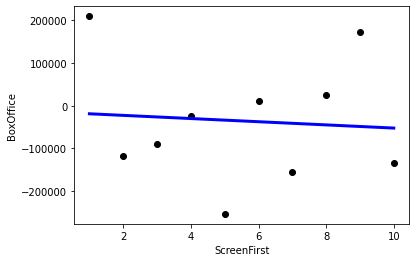

In [254]:
import matplotlib.pyplot as plt

plt.scatter(x, y, color='black')
plt.plot(x, predictions, color='blue', linewidth=3)
plt.xlabel('ScreenFirst')
plt.ylabel('BoxOffice')
plt.show()

In [255]:
# 회귀계수(기울기)
round(model.params[1],3)

-3714.201

## 4-2. 외국인 체결강도 일평균(2주간)  
> 일별 (외국인매수거래량/외국인매도거래량)*100 의 평균(2주)

### 4-2-1. KOSPI 전처리

In [143]:
# foreign_kospi_18 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210318.csv",encoding="CP949")
# foreign_kospi_19 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210319.csv",encoding="CP949")
# foreign_kospi_22 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210322.csv",encoding="CP949")
# foreign_kospi_23 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210323.csv",encoding="CP949")
# foreign_kospi_24 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210324.csv",encoding="CP949")
# foreign_kospi_25 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210325.csv",encoding="CP949")
# foreign_kospi_26 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210326.csv",encoding="CP949")
# foreign_kospi_29 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210329.csv",encoding="CP949")
# foreign_kospi_30 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210330.csv",encoding="CP949")
# foreign_kospi_31 = pd.read_csv("./datasets/raw/foreign/KOSPI_외국인/KOSPI_20210331.csv",encoding="CP949")

# foreign_kospi = pd.concat([foreign_kospi_18, foreign_kospi_19, foreign_kospi_22,
#                         foreign_kospi_23, foreign_kospi_24, foreign_kospi_25,
#                         foreign_kospi_26, foreign_kospi_29, foreign_kospi_30,
#                         foreign_kospi_31], axis=0)
# foreign_kospi = foreign_kospi[foreign_kospi["투자자구분코드"]==9000]

In [144]:
# foreign_kospi = foreign_kospi[['거래일자','종목코드', '종목명', '매도거래량', '매수거래량']]
# # find_over12(foreign_kospi, "종목코드") # 종목코드 12가 아닌게 있는지 check!
# foreign_kospi["종목코드"] = foreign_kospi["종목코드"].map(extract_code)

# # 체결강도계산
# foreign_kospi = foreign_kospi.groupby('종목코드')['매도거래량','매수거래량'].sum()
# foreign_kospi['외국인체결강도'] = np.round(foreign_kospi['매수거래량'] / foreign_kospi['매도거래량']*100, 4)
# foreign_kospi.reset_index(inplace=True,drop=False)
# foreign_kospi = foreign_kospi[['종목코드', '외국인체결강도']]
# foreign_kospi

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_69697/860085545.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  foreign_kospi = foreign_kospi.groupby('종목코드')['매도거래량','매수거래량'].sum()


,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
876,375500,92.6857
877,37550K,43.4761
878,378850,99.0567
879,5307W1,97.5634


### 4-2-2. KOSDAQ 전처리

In [145]:
# foreign_kosdaq_18 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210318.csv",encoding="CP949")
# foreign_kosdaq_19 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210319.csv",encoding="CP949")
# foreign_kosdaq_22 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210322.csv",encoding="CP949")
# foreign_kosdaq_23 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210323.csv",encoding="CP949")
# foreign_kosdaq_24 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210324.csv",encoding="CP949")
# foreign_kosdaq_25 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210325.csv",encoding="CP949")
# foreign_kosdaq_26 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210326.csv",encoding="CP949")
# foreign_kosdaq_29 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210329.csv",encoding="CP949")
# foreign_kosdaq_30 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210330.csv",encoding="CP949")
# foreign_kosdaq_31 = pd.read_csv("./datasets/raw/foreign/KOSDAQ_외국인/KOSDAQ_20210331.csv",encoding="CP949")

# foreign_kosdaq = pd.concat([foreign_kosdaq_18, foreign_kosdaq_19, foreign_kosdaq_22,
#                         foreign_kosdaq_23, foreign_kosdaq_24, foreign_kosdaq_25,
#                         foreign_kosdaq_26, foreign_kosdaq_29, foreign_kosdaq_30,
#                         foreign_kosdaq_31], axis=0)
# foreign_kosdaq = foreign_kosdaq[foreign_kosdaq["투자자구분코드"]==9000]

In [146]:
# foreign_kosdaq = foreign_kosdaq[['거래일자','종목코드', '종목명', '매도거래량', '매수거래량']]
# # find_over12(foreign_kosdaq, "종목코드") # 종목코드 12가 아닌게 있는지 check!
# foreign_kosdaq["종목코드"] = foreign_kosdaq["종목코드"].map(extract_code)
# # 체결강도 계산
# foreign_kosdaq = foreign_kosdaq.groupby('종목코드')['매도거래량','매수거래량'].sum()
# foreign_kosdaq['외국인체결강도'] = np.round(foreign_kosdaq['매수거래량'] / foreign_kosdaq['매도거래량']*100, 4)
# foreign_kosdaq.reset_index(inplace=True,drop=False)
# foreign_kosdaq = foreign_kosdaq[['종목코드', '외국인체결강도']]
# foreign_kosdaq

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_69697/2234554989.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  foreign_kosdaq = foreign_kosdaq.groupby('종목코드')['매도거래량','매수거래량'].sum()


,종목코드,외국인체결강도
0,000057,118.6383
1,000214,63.7143
2,000250,87.1595
3,000295,174.8541
4,000312,99.9582
...,...,...
1391,3931T1,139.0402
1392,840090,143.1100
1393,840110,155.1762
1394,840140,67.7880


### 4-2-3. 체결강도 계산

In [153]:
# df_체결강도 = pd.concat([foreign_kospi, foreign_kosdaq], axis=0) # 회사수가 적은 쪽을 기준으로 합친다.(1748 vs 2331)
# df_체결강도.reset_index(inplace=True, drop=True)
# df_체결강도

,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
2272,3931T1,139.0402
2273,840090,143.1100
2274,840110,155.1762
2275,840140,67.7880


In [154]:
# df_체결강도.to_csv("./datasets/raw/df_체결강도.csv") #로 csv추출

### 4-2-4. 체결강도 불러오기

In [155]:
df_체결강도 = pd.read_csv("./datasets/raw/df_체결강도.csv", index_col=0)
df_체결강도

,종목코드,외국인체결강도
0,000020,82.8318
1,000040,99.4166
2,000050,76.5410
3,000060,157.1337
4,000070,103.0182
...,...,...
2272,3931T1,139.0402
2273,840090,143.1100
2274,840110,155.1762
2275,840140,67.7880
